# Statistical Analyses for measuring the impact of COVID-19 Vaccine Misinformation on COVID-19 Vaccine Acceptance
This notebook covers all statistical models that generate results and figures in the main paper and supplementary. Transformed survey data are used.

We use `pystan` package, which is the Python implementation of the [Stan](https://mc-stan.org/) platform for statistical modeling. This package allows us to perform full Bayesian inference using Hamiltonian Monte Carlo via No-U-Turn Sampler (NUTS).

We begin by importing the processed data for the UK (see `import_data.ipynb` for more details). The `src.utils.py` file provides many helper functions which we will frequently use to generate tables and figures for the paper.

In [36]:
%matplotlib inline
import src.utils as ut
NUM_SAMPLES = 200 #here we have set samples to just 200 (x 4 chains), but in the paper we use 2000 samples for more credible estimates

In [19]:
from importlib import reload

In [29]:
df, dd = ut.import_transformed_data('dat/orb_uk')

## Impact of Exposure to Misinformation
We begin by modeling the impact of exposure of (mis)information on COVID-19 vaccine acceptance. As noted in the paper, vaccine acceptance is a 4-class ordinal variable going from "Yes, definitely" to "No, definitely not". See the "Statistical Methods" section of the paper; specific model specs will be referred to in the code below.

Below is a function that essentially defines the corresponding Stan model, and fits it with the given data.

In [31]:
def model_impact(df, group=1., kind='self', prior_mu=1., prior_sigma=1., iters=NUM_SAMPLES):
    # Model: Ref 1, Table 3
    # Results: Table 2
    import pystan as st
    model_code = '''
                    data {
                        int<lower=0> n; //number of data points
                        int<lower=1> m; //number of conditions
                        int<lower=2> k; //number of outcomes
                        int<lower=1,upper=k> y[n,m]; //outcome per sample per condition
                    }
                    parameters {
                        real mu[k-1];
                        real<lower=0> sigma[k-1];
                        ordered [k-1] alpha[m];
                    }
                    model {
                        for (i in 1:(k-1)) {
                            mu[i] ~ normal(0, %f);
                            sigma[i] ~ exponential(%f);
                        }
                        for (i in 1:m)
                            alpha[i] ~ normal(mu, sigma);
                        for (i in 1:n)
                            for (j in 1:m)
                                y[i,j] ~ ordered_logistic(0, alpha[j]);
                    }
                '''%(prior_mu, prior_sigma)
    if group is not None: df = df.loc[df['Treatment']==group]
    data = {'n':df.shape[0], 'm':2, 'k':4, 'y':df[['Vaccine Intent for %s (Pre)'%kind, 'Vaccine Intent for %s (Post)'%kind]].values}
    model = st.StanModel(model_code=model_code)
    fit = model.sampling(data=data, iter=iters)
    return fit

Let's call the above function to generate the fit object, when modeling impact of exposure to misinformation (treatment group).

In [32]:
fit_impact_T = model_impact(df, group=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_051c2df6945ffd129449f7712dd290c3 NOW.


This object's `plot()` and `print()` methods allow us to see a quick summary of the model parameters. In particular, we are looking for well-mixed chains in the trace plots, and the Rhat statistic to be close to 1.

Inference for Stan model: anon_model_051c2df6945ffd129449f7712dd290c3.
4 chains, each with iter=200; warmup=100; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=400.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        0.04    0.02   0.35  -0.65  -0.14   0.04   0.23   0.87    261   1.01
mu[2]         1.2    0.05   0.56  -0.33   0.98   1.33   1.58   2.02    149   0.99
mu[3]        1.81     0.1   0.85  -0.52   1.46   2.08   2.39   2.88     76   1.02
sigma[1]     0.51    0.05   0.46    0.1   0.24   0.39   0.64   1.55    101   1.07
sigma[2]     0.75    0.06   0.59   0.17   0.32   0.56   0.97   2.33    105    1.0
sigma[3]     0.97    0.09   0.88   0.13   0.35   0.71   1.36   2.92    102   1.02
alpha[1,1]   0.16  2.0e-3   0.04   0.09   0.14   0.16   0.19   0.24    360    1.0
alpha[2,1]  -0.09  1.5e-3   0.03  -0.15  -0.12   -0.1  -0.07  -0.04    426   0.99
alpha[1,2]   1.79  2.5e-3   0.06   1.68   1.75   1.79   1.83    1.9    480   

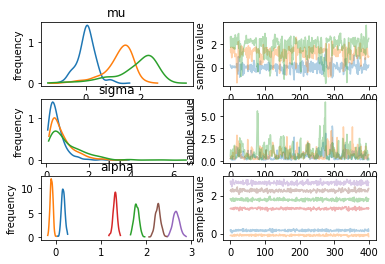

In [33]:
fit_impact_T.plot()
print(fit_impact_T)

A clear distinction of the $\alpha$ corresponding to pre- and post-exposure is visible in the third plot, which would indicate differences after misinformation exposure. We can use some helper functions to generate the posterior statistics---parameter mean to judge effect size and 95% percentile intervals (PI) to judge "significance"---of the distribution across the 4 vaccine acceptance categories from this fit object. This contributes to **Table 2** of the paper.

In [50]:
fit2stats_impact_T = ut.stats_impact(fit_impact_T)
print(fit2stats_impact_T)

                                      mean      2.5%     97.5%
Pre Exposure  Yes, definitely     0.540643  0.522187  0.560689
              Unsure, lean yes    0.315931  0.297623  0.332839
              Unsure, lean no     0.078514  0.068266  0.088301
              No, definitely not  0.064912  0.056396  0.073359
Post Exposure Yes, definitely     0.476482  0.462095  0.490461
              Unsure, lean yes    0.311729  0.297121  0.326887
              Unsure, lean no     0.117550  0.106898  0.129421
              No, definitely not  0.094240  0.084757  0.104831
Post-Pre      Yes, definitely    -0.064161 -0.086019 -0.043465
              Unsure, lean yes   -0.004203 -0.025401  0.016586
              Unsure, lean no     0.039036  0.023926  0.053986
              No, definitely not  0.029328  0.015529  0.042707


Looking at the difference of post and pre exposures, we see a significant (PI excludes 0) drop in people who would "definitely" accept the vaccine, and a significant rise in those who are unsure but leaning towards no, or definitely will not accept the vaccine. Similarly, we can repeat this analysis for exposure to factual information (control group).

In [51]:
fit_impact_C = model_impact(df, group=0)
fit2stats_impact_C = ut.stats_impact(fit_impact_C)
print(fit2stats_impact_C)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_051c2df6945ffd129449f7712dd290c3 NOW.


                                      mean      2.5%     97.5%
Pre Exposure  Yes, definitely     0.540566  0.515304  0.569765
              Unsure, lean yes    0.326975  0.300193  0.354038
              Unsure, lean no     0.085272  0.070760  0.102059
              No, definitely not  0.047186  0.035373  0.061836
Post Exposure Yes, definitely     0.546568  0.518428  0.572214
              Unsure, lean yes    0.319365  0.293458  0.344823
              Unsure, lean no     0.085369  0.068923  0.101580
              No, definitely not  0.048699  0.037624  0.060944
Post-Pre      Yes, definitely     0.006001 -0.029628  0.043697
              Unsure, lean yes   -0.007611 -0.041781  0.024433
              Unsure, lean no     0.000097 -0.022323  0.020930
              No, definitely not  0.001513 -0.014967  0.018260


Here, we do not see a significant change in the distribution of respondents across any vaccine acceptance category (PI includes 0).

### Causal Risk Difference

However, as demonstrated in `import_data.ipynb`, it's not the case that people do not change their vaccine opinions at all. This can be due to recall-bias, or other individual-effects, which "cancel" out in a manner that the aggregate distribution in the society remains the same. This can be better understood by computing a "risk-difference" of exposure to misinformation over exposure to factual-information---see Equation 2 of the paper.

In [58]:
def model_impact_causal(df, kind='self', prior_mu=1., prior_sigma=1., prior_rho=1., iters=NUM_SAMPLES):
    # Model: Appendix C
    # Results: Tables S1, S2; Figures S1, S2
    import pystan as st
    model_code = '''
                data {
                    int<lower=0> n; //number of data points
                    int<lower=1> m; //number of conditions
                    int<lower=2> k; //number of outcomes
                    int<lower=1,upper=m> x_cond[n]; //treatment group
                    int<lower=1,upper=k> y_pre[n]; //pre-exposure outcome
                    int<lower=1,upper=k> y_post[n]; //post-exposure outcome
                }
                parameters {
                    real mu_alpha[k-1];
                    real mu_beta;
                    real<lower=0> sigma_alpha[k-1];
                    real<lower=0> sigma_beta;
                    real<lower=0> sigma_delta;
                    simplex[k-1] delta_delta;
                    simplex[k-1] delta[m];
                    real beta[m];
                    ordered[k-1] alpha[m];
                }
                model {
                    mu_alpha ~ normal(0, %f);
                    mu_beta ~ normal(0, %f);
                    sigma_alpha ~ exponential(%f);
                    sigma_beta ~ exponential(%f);
                    sigma_delta ~ exponential(%f);
                    {
                        vector[k-1] u;
                        for (i in 1:(k-1))
                            u[i] = 1;
                        delta_delta ~ dirichlet(%f*u);
                    }
                    for (i in 1:m){
                        beta[i] ~ normal(mu_beta, sigma_beta);
                        alpha[i] ~ normal(mu_alpha, sigma_alpha);
                        delta[i] ~ dirichlet(sigma_delta*delta_delta);
                    }
                    for (i in 1:n)
                        y_post[i] ~ ordered_logistic(beta[x_cond[i]]*sum(delta[x_cond[i]][:y_pre[i]-1]), alpha[x_cond[i]]);
                }
            '''%(prior_mu, prior_mu, prior_sigma, prior_sigma, prior_sigma, prior_rho)
    
    data = {'n':df.shape[0], 'm':2, 'k':4, 'x_cond':df['Treatment'].values+1, 
            'y_pre':df['Vaccine Intent for %s (Pre)'%kind].values, 
            'y_post':df['Vaccine Intent for %s (Post)'%kind].values}
    model = st.StanModel(model_code=model_code)
    fit = model.sampling(data=data, iter=iters)
    return fit

In [40]:
fit_impact_causal = model_impact_causal(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce16927ba6ef8fb803021d0fa421b63f NOW.


In [56]:
fit2stats_impact_causal = ut.stats_impact_causal(fit_impact_causal)

In [57]:
print(fit2stats_impact_causal)

                                                             mean      2.5%  \
Control           Yes, definitely    Yes, definitely     0.912317  0.886677   
                                     Unsure, lean yes    0.085844  0.065050   
                                     Unsure, lean no     0.001688  0.000997   
                                     No, definitely not  0.000151  0.000076   
                  Unsure, lean yes   Yes, definitely     0.169845  0.132862   
                                     Unsure, lean yes    0.744419  0.700287   
                                     Unsure, lean no     0.078021  0.055363   
                                     No, definitely not  0.007715  0.003874   
                  Unsure, lean no    Yes, definitely     0.009036  0.004761   
                                     Unsure, lean yes    0.310087  0.229724   
                                     Unsure, lean no     0.531137  0.441607   
                                     No, definitely 

The above contributes to **Tables S1, S2** and **Figures S1, S2** of the paper. Let's generate those figures for a simple visual interpretation by using a helper function.

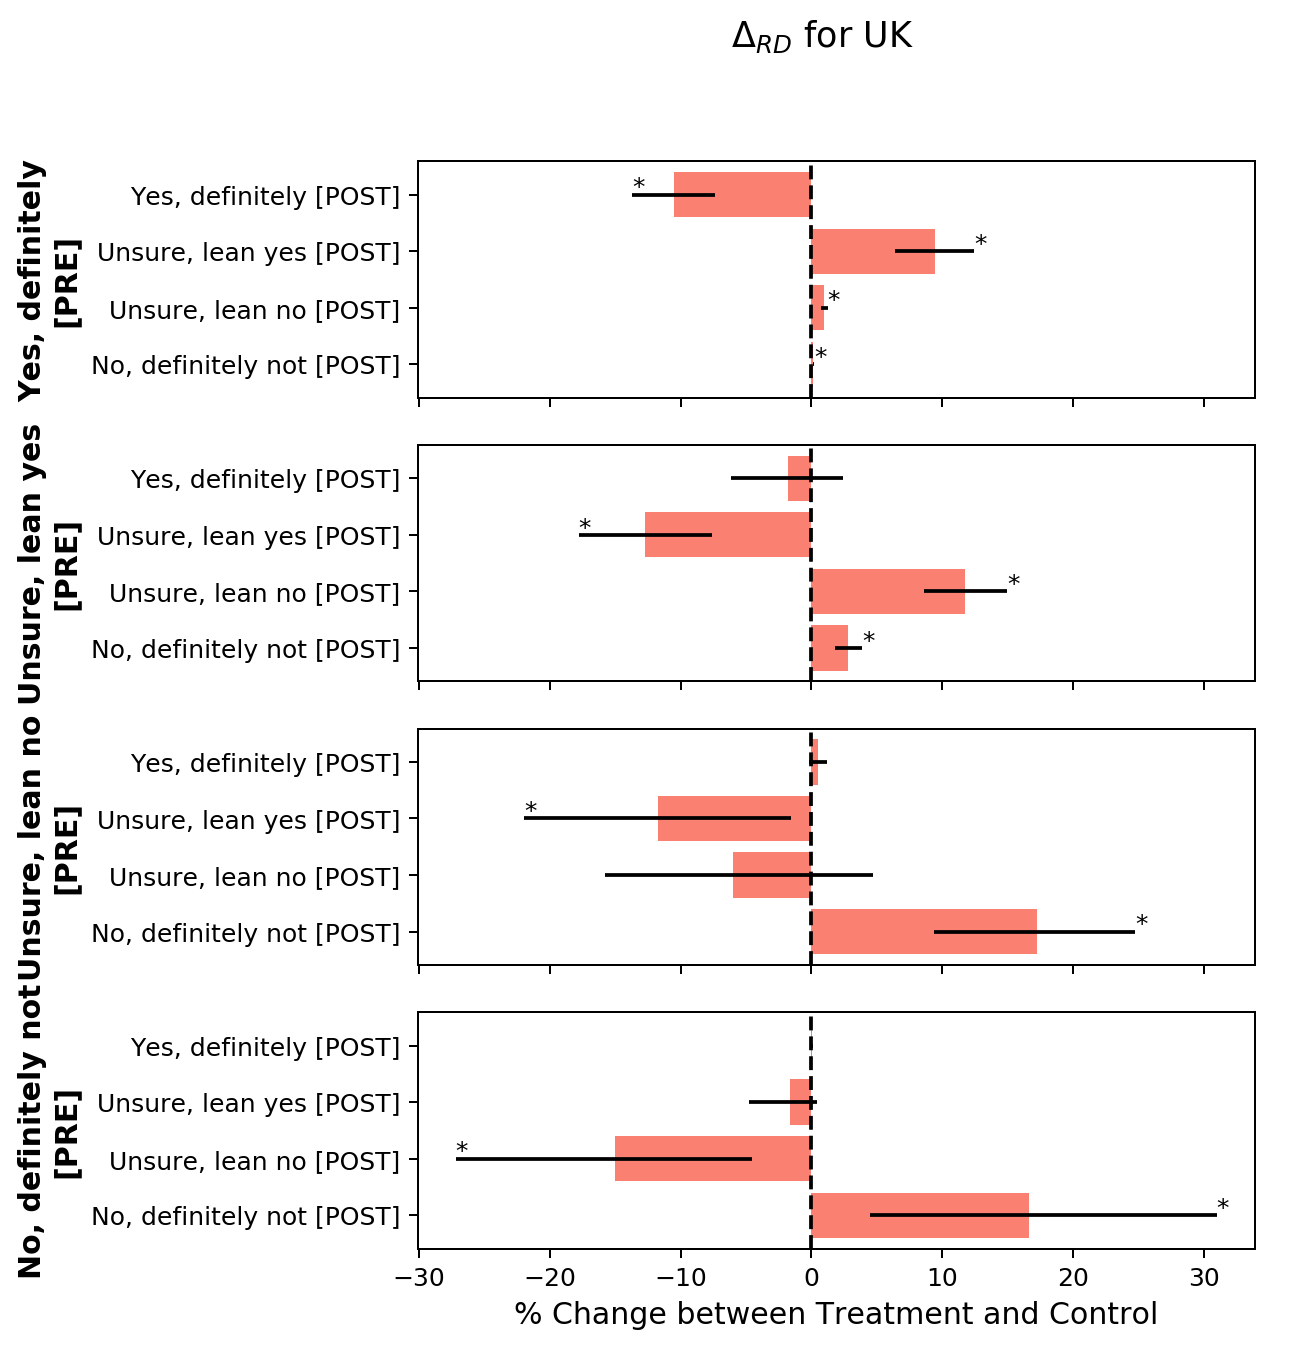

In [48]:
ut.plot_stats(fit2stats_impact_causal.loc['Treatment-Control']*100, oddsratio=False, title='$\\Delta_{RD}$ for UK', xlab='% Change between Treatment and Control', tick_suffix=' [POST]', label_suffix='\n[PRE]', factor=0.5)

It's evident that overall, respondents tend to transition from higher vaccine acceptance categoris to lower ones upon exposure to misinformation, relative to exposure to factual-information. An alternate representation of the entire above analysis is to draw Sankey plots which show the "flow" of people pre- and post-exposure to information.

In [54]:
ut.plot_causal_flow(fit2stats_impact_causal, fit2stats_impact_T, fit2stats_impact_C)

## Determinants of Vaccine Hesitancy and Susceptibility to Misinformation
Once we have established that misinformation does impact vaccine acceptance, we can look at the socio-econo-demographic determinants of this hesitancy, and if certain groups of people might be more susceptible to COVID-19 vaccine misinformation.

To that end, we define a model which will determine the contribution of any variable to vaccine intent, while controling for the socio-demographic information.

In [64]:
def model_socdem(df, dd, atts=[], group=None, prior_beta=1., prior_delta=1., prior_alpha=1., iters=NUM_SAMPLES):
    # Model: Ref 2, 3, 4, 5 in Table 3
    # Results: Tables S3, S4, S5; Figures 3, 4
    import pystan as st
    import numpy as np
    from src.bayesoc import Dim #we define some helper classes to extract posterior samples easily
    cats = ['Age', 'Gender', 'Education', 'Employment', 'Religion', 'Political', 'Ethnicity', 'Income']
    if isinstance(atts, str): atts = [atts]
    for att in atts: cats += [x for x in list(df) if x[:len(att)]==att]
    outs = ['Vaccine Intent for self (Pre)', 'Vaccine Intent for self (Post)', 'Treatment']
    df = df[cats+outs].dropna()
    dims = [Dim(pi=len(dd[cat]), beta_prior=prior_beta, value=dd[cat].keys(), name=cat) for cat in cats]
    stan = [d.get_stan() for d in dims]
    code = {'data':[], 'parameters':[], 'model':[], 'output':[]}
    for key in code:
        for d in stan: code[key].append(d[key])        
    mod_cd = '''
                data {
                    int<lower=1> n; //number of data points
                    int<lower=2> k; //number of outcomes
                    int<lower=1,upper=k> y_pre[n]; //pre-exposure
                    int<lower=1,upper=k> y_post[n]; //post-exposure
                    %s
                }
                parameters {
                    %s
                    simplex[k-1] delta;
                    ordered[k-1] alpha;
                }
                model {
                    %s
                    {
                        vector[k-1] u;
                        for (i in 1:(k-1))
                            u[i] = 1;
                        delta ~ dirichlet(%f*u);
                    }
                    alpha ~ normal(0, %f);
                    for (i in 1:n)
                        y_post[i] ~ ordered_logistic((%s)*sum(delta[:y_pre[i]-1]), alpha);
                }
            '''%('\n'.join(code['data']), '\n'.join(code['parameters']), '\n'.join(code['model']), prior_delta, prior_alpha, ' + '.join(code['output']))
    
    mod_bs = '''
                data {
                    int<lower=1> n; //number of data points
                    int<lower=2> k; //number of outcomes
                    int<lower=1,upper=k> y_pre[n]; //pre-exposure
                    %s
                }
                parameters {
                    %s
                    ordered[k-1] alpha;
                }
                model {
                    %s
                    alpha ~ normal(0, %f);
                    for (i in 1:n)
                        y_pre[i] ~ ordered_logistic(%s, alpha);
                }
            '''%('\n'.join(code['data']), '\n'.join(code['parameters']), '\n'.join(code['model']), prior_alpha, ' + '.join(code['output']))
    
    data = {}
    if group is not None:
        df = df.loc[df['Treatment']==group]
        data['y_post'] = df['Vaccine Intent for self (Post)'].values
    data['n'] = df.shape[0]
    data['k'] = 4
    data['y_pre'] = df['Vaccine Intent for self (Pre)'].values        
    print('Dataframe of size:', df.shape)
    for i in range(len(cats)):
        name = dims[i].name
        data['k_%s'%name] = len(dd[cats[i]])
        data[name] = np.array(df[cats[i]].values, dtype=int)
        if data[name].min()==0: data[name] += 1
    if group is None: model = st.StanModel(model_code=mod_bs)
    else: model = st.StanModel(model_code=mod_cd)
    fit = model.sampling(data=data, iter=iters)
    return fit

### Socio-demographics and Social Media Usage
First, let us explore how social media usage might contribute to pre-exposure vaccine acceptance. This means a model with the socio-demographic as predictors, alongside social media usage variable, with the outcome being the pre-exposure vaccine intent. As before, we fit the model first.

In [65]:
fit_socdem_preexposure = model_socdem(df, dd, 'Social media')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17b00e7697800dd6b389f3d5b09b09bb NOW.


Dataframe of size: (4000, 12)


Next, we extract the posterior statistics for the odds-ratio (OR) of different parameters that we have considered---all socio-demographics, plus social media usage. This contributes to **Table S3** of the paper.

In [81]:
stats_socdem_preexposure = ut.stats_socdem(fit_socdem_preexposure, dd, df, 'Social media', oddsratio=True)
print(stats_socdem_preexposure)

                                                     mean      2.5%     97.5%  \
Age                25-34                         1.081917  0.853941  1.377030   
                   35-44                         1.001682  0.769990  1.251344   
                   45-54                         0.970100  0.758020  1.224177   
                   55-64                         0.758105  0.578985  0.982457   
                   65+                           0.517113  0.353950  0.707797   
Gender             Female                        1.433692  1.269342  1.619139   
                   Other                         2.365496  1.032779  4.131663   
Education          Level-0                       1.851821  1.293225  2.506882   
                   Level-1                       1.579464  1.271074  1.912968   
                   Level-2                       1.497504  1.186259  1.860616   
                   Level-3                       1.215337  0.972045  1.483706   
                   Other    

Next, we do a regression with the same predictors, except by adding the pre-exposure vaccine intent as an additional predictor with the outcome now being the post-exposure vaccine intent. This allows us to find determinants of "susceptibility" to misinformation. This contributes to **Table S3** of the paper.

In [73]:
fit_socdem_susceptibility = model_socdem(df, dd, 'Social media', group=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f7d2593f7d09925e12a1038f65f6904 NOW.


Dataframe of size: (3000, 12)


In [94]:
stats_socdem_susceptibility = ut.stats_socdem(fit_socdem_susceptibility, dd, df, 'Social media', group=1, oddsratio=True)

Instead of printing out the whole table of results, we can use the plotting helper function to do a quick visualisation. This contributes to **Figure 3** of the paper.

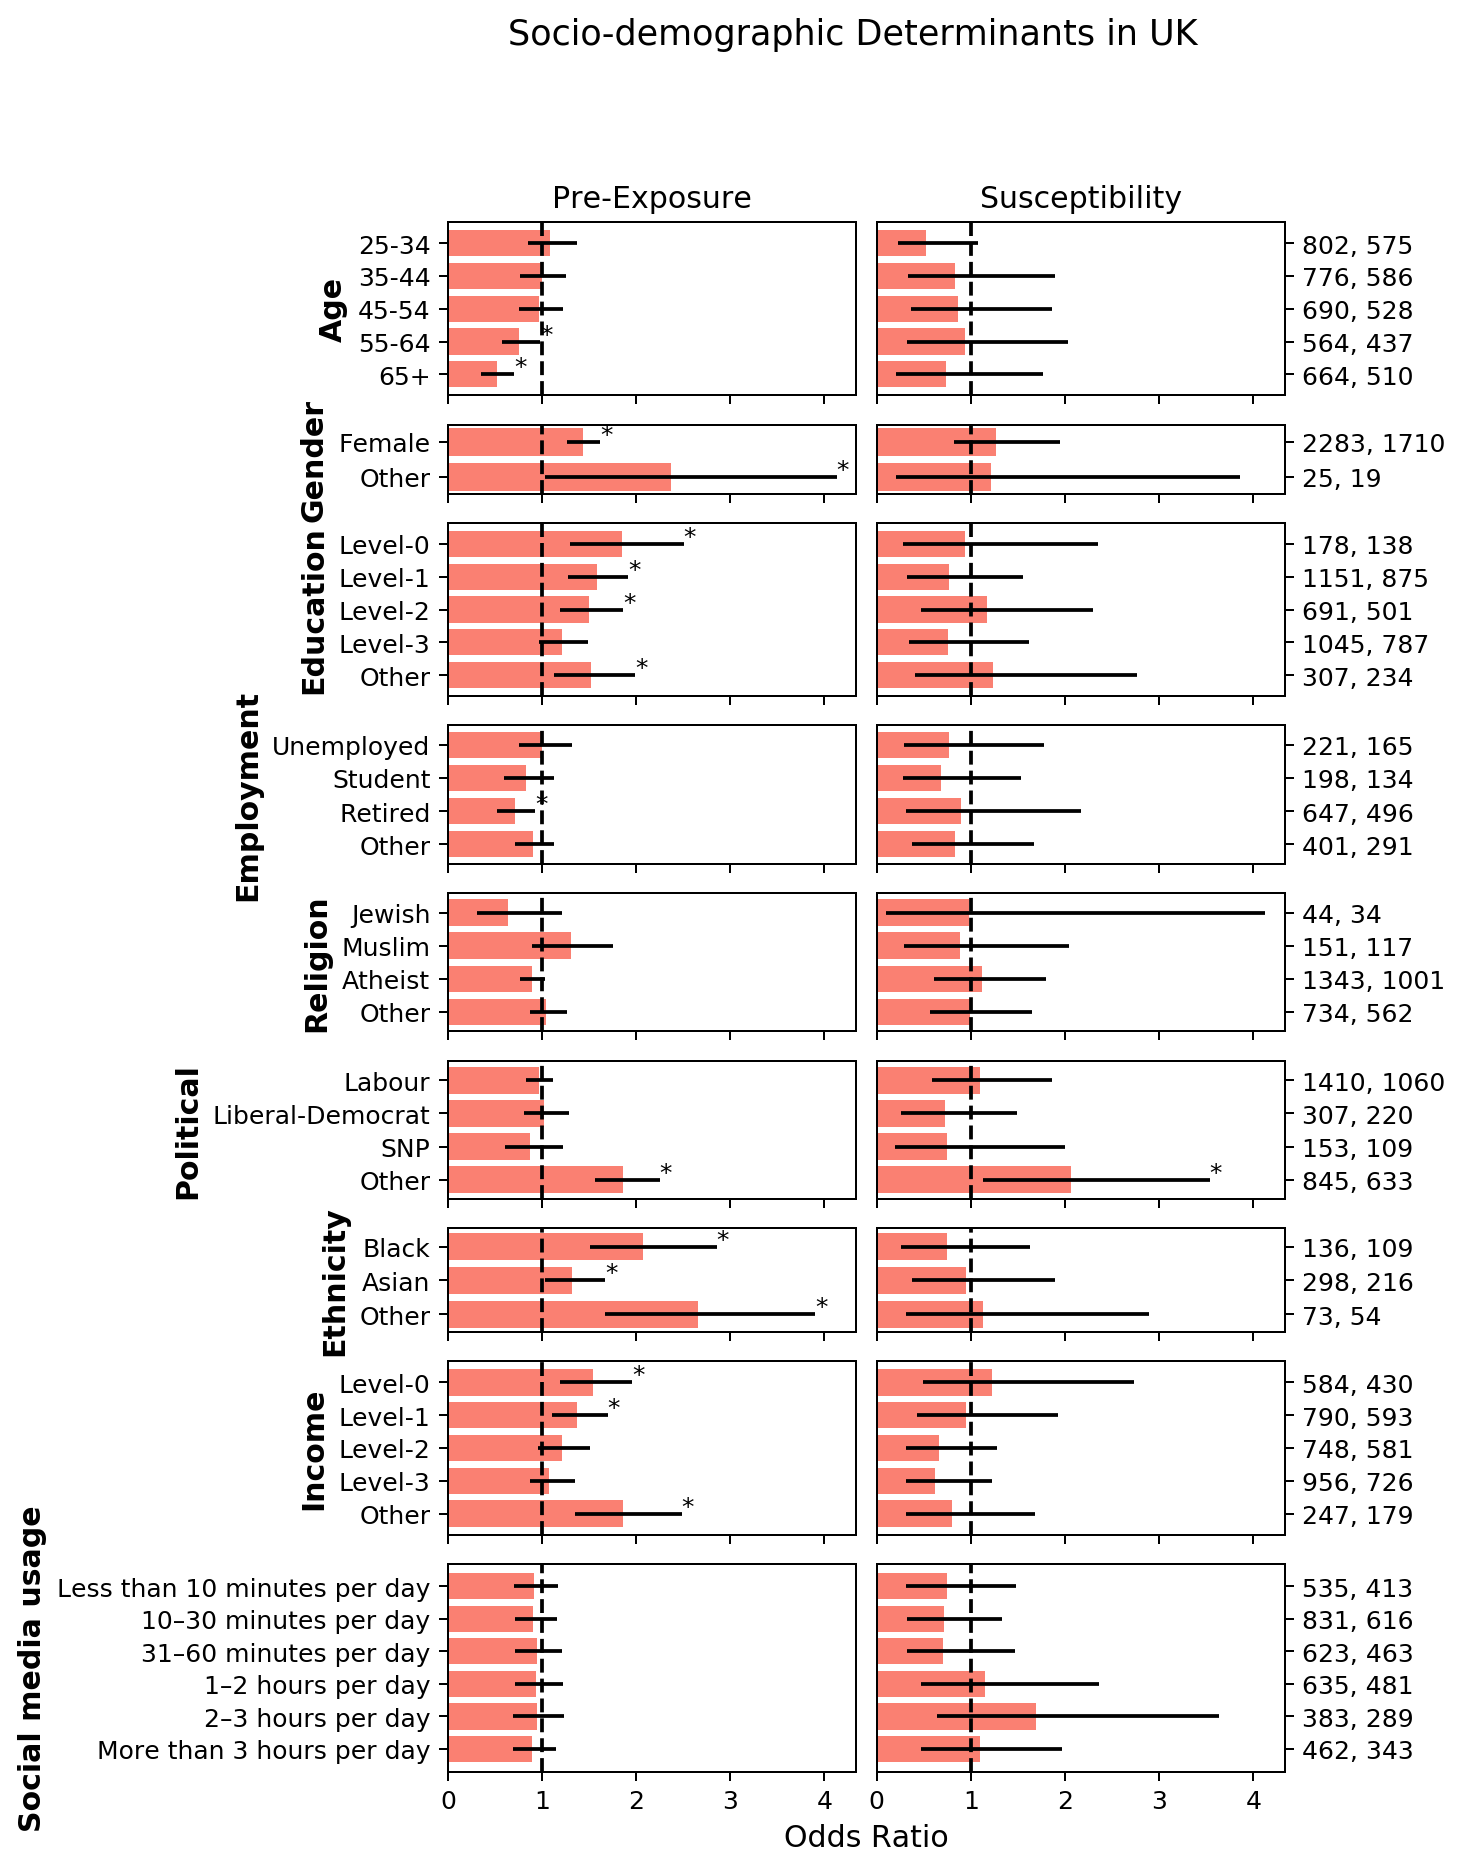

In [95]:
ut.plot_stats(stats_socdem_preexposure, stats_socdem_susceptibility, demos=True, title='Socio-demographic Determinants in UK', title_l='Pre-Exposure', title_r='Susceptibility', xlab='Odds Ratio')

We obtain some interesting results for the UK:
1. Older age groups (55+) are significantly more willing to accept the vaccine than 18-24 year olds (OR<1).
2. Females are significantly less willing to accept the vaccine than males (OR>1).
3. Vaccine acceptance tends to increase with increase in education levels (OR significantly decreases w.r.t. baseline education Level-4). Something similar is observed with increase in income levels.
4. Those who are retired are significantly more accepting of the vaccine when compared to those who are employed (OR<1).
5. Those who do not support any mainstream political party in the UK, i.e. support "Others", are significantly less likely to accept the vaccine than compared to Conservatives (OR>1).
6. Ethnic minorities are significantly less willing to accept a vaccine when compared to Whites (OR>1).
7. Social media usage has no impact on vaccine acceptance (when controlling for all of the above socio-demographics).

### Source of COVID-19 Information that are Trusted
It has been shown that trust plays a very important role when it comes to accessing public health information. We can thus do a similar analysis to observe how having trust in different sources of information for COVID-19 may determine vaccine hesitancy and susceptibility to misinformation.

In [85]:
fit_trust_preexposure = model_socdem(df, dd, 'Trust:')
fit_trust_susceptibility = model_socdem(df, dd, 'Trust:', group=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6744ba266f1a3ea14c140da089e06059 NOW.


Dataframe of size: (4000, 27)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e34bbd859a93c15981ec9c1c04d3f38 NOW.


Dataframe of size: (3000, 27)


Next, we compute the posterior statistics. This contributes to **Table S5** of the paper. This time, we will compute the log of ORs, since `+`/`-` log OR values make for easier interpretation in terms of ranking determinants by the magnitude of log ORs, than judging by `>1`/`<1` for OR values.

In [96]:
stats_trust_preexposure = ut.stats_socdem(fit_trust_preexposure, dd, df, 'Trust:', oddsratio=False)
stats_trust_susceptibility = ut.stats_socdem(fit_trust_susceptibility, dd, df, 'Trust:', group=1, oddsratio=False)

We can use the same helper function to plot the statistics for us. This contributes to **Figure 4** of the paper.

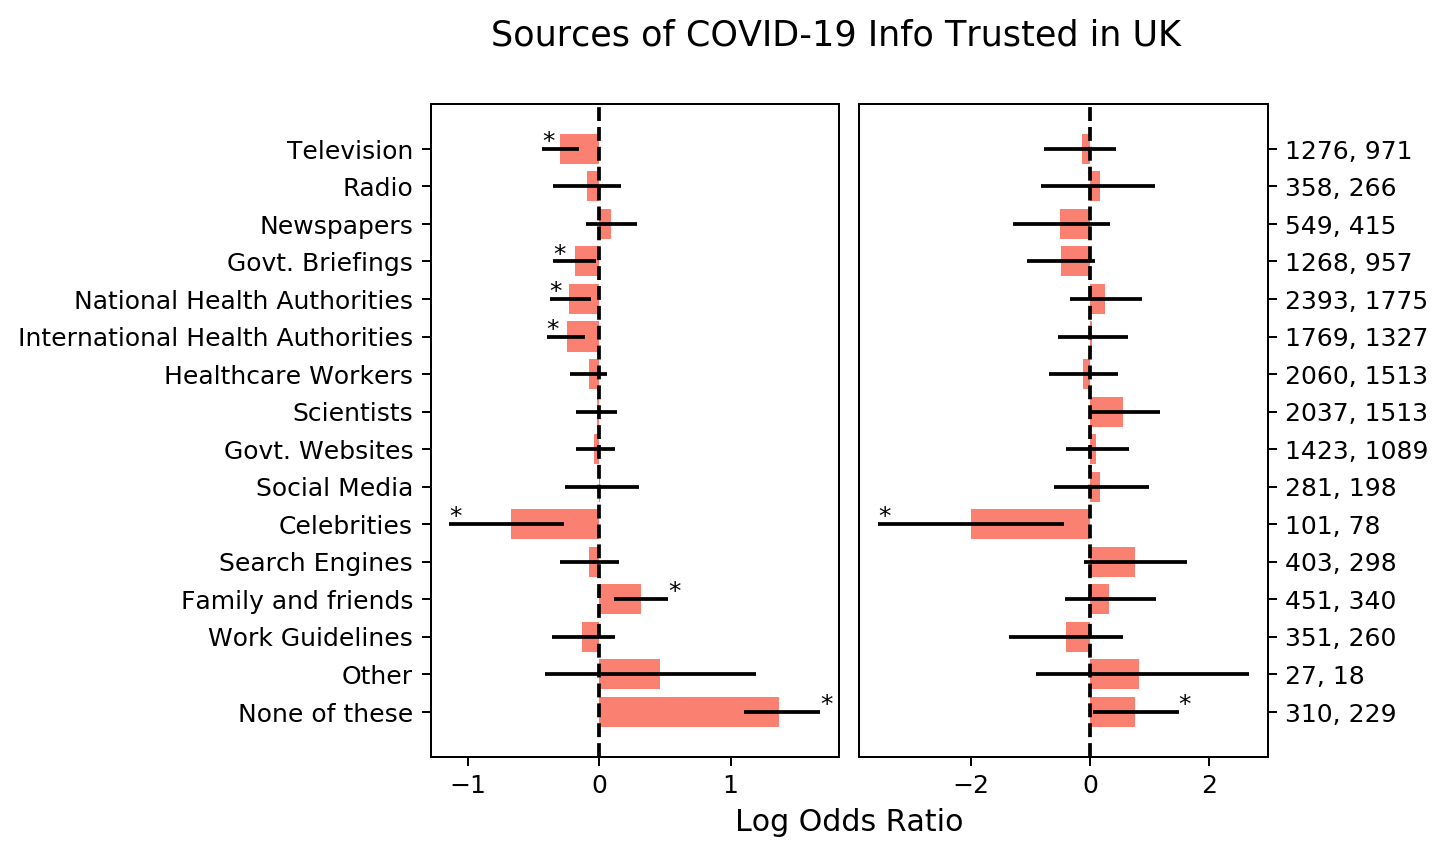

In [97]:
ut.plot_stats(stats_trust_preexposure, stats_trust_susceptibility, title='Sources of COVID-19 Info Trusted in UK', oddsratio=False, ylabel=False, xlab='Log Odds Ratio')

Clearly, the largest determinant of pre-exposure vaccine acceptance is _not_ trusting any of the mainstream sources of information. Although this pool of people isn't huge (see the sample counts on the right-hand axis of the plot), they are significantly less likely to accept the vaccine than those who trust _some_ conventional source of information. This group of people was also more susceptible to misinformation.

Whereas those who trusted TV news, government briefings, health authorities, and perhaps surprisingly celebrities, were more willing to accept the vaccine. Those indicating trust in Family and Friends were significantly more unwilling to accept the vaccine, which could indicate that receicing information from informal sources does not fare positively for COVID-19 vaccine acceptance.
### Reasons for Vaccine Hesitancy
Those who did not indicate that they will "definitely" accept the vaccine were asked for their reasons to be hesitant. This can provide some insight into psycho-social determinants of hesitancy and susceptibility.

In [92]:
fit_reason_preexposure = model_socdem(df, dd, 'Reason:')
fit_reason_susceptibility = model_socdem(df, dd, 'Reason:', group=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c89fa2eafc78344e80b290d30ce9a857 NOW.


Dataframe of size: (1833, 21)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_908e4fb570dec568da3419f5c54ac780 NOW.


Dataframe of size: (1375, 21)


Next, we compute the posterior statistics and visualise them, which contributes to **Table S4** and **Figure 4** of the paper.

In [98]:
stats_reason_preexposure = ut.stats_socdem(fit_reason_preexposure, dd, df, 'Reason:', oddsratio=False)
stats_reason_susceptibility = ut.stats_socdem(fit_reason_susceptibility, dd, df, 'Reason:', group=1, oddsratio=False)

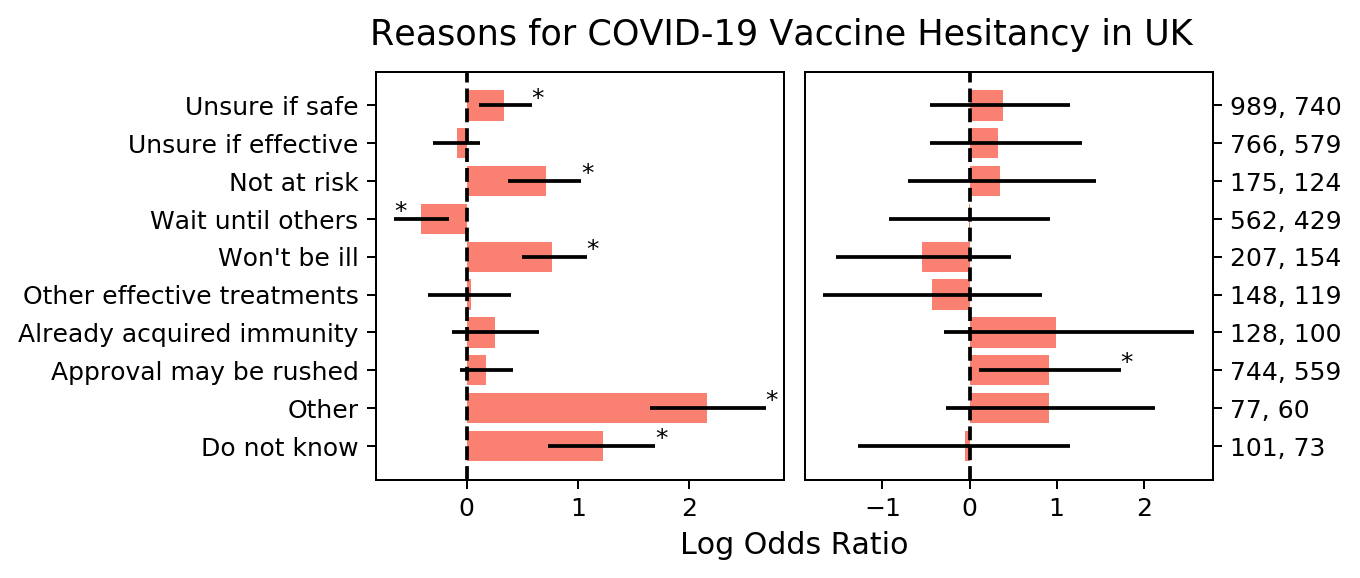

In [99]:
ut.plot_stats(stats_reason_preexposure, stats_reason_susceptibility, title='Reasons for COVID-19 Vaccine Hesitancy in UK', oddsratio=False, ylabel=False, xlab='Log Odds Ratio')

Evidently, only the group of people indicating they will "wait until others" received the vaccine, were significantly on the lower-end of COVID-19 vaccine hesitancy. Those indicating they were "not at risk" or "won't be ill" probably believe the risk of accepting the vaccine outweigh its need, and thus are also less willing to accept it. Those indicating worries about vaccine safety are also more unsure about the vaccine. But the largest contribution is those indicating "other" reasons, which do not fall into these "expected" reasons of hesitancy.

In terms of susceptibility, it seems like the only group that is significantly more susceptible is the one which indicated that the vaccine "approval may be rushed". This hints at the kind of psychological effect exposure to the misinformation images may have had on the respondents, perhaps provoking that fear of rushed approval.

In [79]:
reload(ut)

<module 'src.utils' from 'C:\\Users\\sahil\\OneDrive - Imperial College London\\phd\\dat\\covid19\\covid19-misinfo\\src\\utils.py'>